# Working with XDF data using MNE
The goal of this notebook is to import data saved using the LSL Lab Recorder, and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [48]:
import mne
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pyxdf
import numpy as np
import time
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample
from meegkit import dss
from meegkit.utils import fold, rms, tscov, unfold
import librosa # optional, only needed to convert MIDI keys to notes

## Path to dataset

In [2]:
condition = 'diverse-wrong'
DATA_PATH = f'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001/{condition}/'
DATA_PATH+= f'sub-matthias_ses-S001_task-Default_run-001_{condition}.xdf'

#DATA_PATH = r'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/active_piano/sub-matthias/ses-S001/diverse/'
#DATA_PATH+= 'sub-matthias_ses-S001_task-Default_run-001_diverse.xdf'

In [3]:
# Read in the LSL streams from the XDF file
START_TIME = time.time()
streams, header = pyxdf.load_xdf(DATA_PATH) # this could take ~80 seconds..
print(f'Loaded in {time.time() - START_TIME} s')

Loaded in 67.14845705032349 s


## Check the duration of each recorded stream

In [4]:
for s in streams:
    name = s['info']['name']
    
    # the footer timestamps might be coming from different machines?
    first_timestamp = float(s['footer']['info']['first_timestamp'][0])
    last_timestamp = float(s['footer']['info']['last_timestamp'][0])
    print(name, first_timestamp, last_timestamp, last_timestamp -first_timestamp)
    
    # These seem more comparable
    print(s['time_stamps'][0])

['CGX Quick-32r Q32r-0524 Impedance'] 629107.4464764 629786.0089744 678.5624979999848
629107.376903456
['CGX Quick-32r Q32r-0524'] 629107.4464736 629786.0089742 678.5625006000046
629107.3769039948
['glove_data'] 19560.898203049 20239.471641428 678.5734383790004
629107.4410032643
['MIDIStream'] 19576.212527043 20187.340799252 611.128272209
629122.755649534
['ev_ts'] 28993.876659933 29671.97202192 678.0953619869979
629107.5798429272
['MyAudioStream'] 629107.5272584757 629786.0682443557 678.5409858800704
629107.4622192689


In [5]:
# Get the first time stamp across all streams (read from time_stamps)
first_timestamps = []

for s in streams: # loop through remaining streams
    s_name = s['info']['name']
    t0 = s['time_stamps'][0]
    print(t0, '\t', s_name)
    
    first_timestamps.append(t0)
    
first_timestamp = min(first_timestamps)
print(first_timestamp, '\t', '<== earliest')   

629107.376903456 	 ['CGX Quick-32r Q32r-0524 Impedance']
629107.3769039948 	 ['CGX Quick-32r Q32r-0524']
629107.4410032643 	 ['glove_data']
629122.755649534 	 ['MIDIStream']
629107.5798429272 	 ['ev_ts']
629107.4622192689 	 ['MyAudioStream']
629107.376903456 	 <== earliest


# Collect stream info and data

In [45]:
lsl_streams = {} # for collecting time stamps and data

# Identify EEG data and impedance streams separately to collect metadata (channel names, etc)
# Remaining streams are collected in one dict

for s in streams:
    s_name = s['info']['name'][0]
    s_type = s['info']['type'][0]
    print(f'Stream Name: {s_name}\tType: {s_type}')
    print('-'*50)
    
    # Get the EEG data stream for CGX
    if ('CGX' in s_name) and (s_type == 'EEG'):
        eeg_data = s['time_series']
        eeg_t = s['time_stamps'] - first_timestamp # offset first time stamp to t=0
        eeg_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_sfreq = s['info']['effective_srate']
        print(f'Channels: {eeg_ch_names}')
        print(f'Unit: {eeg_ch_units}')
        print(f'Eff. Sampling Rate: {eeg_sfreq} Hz')
        
    # Get the impedance data stream for CGX
    elif ('CGX' in s_name) and (s_type == 'Impeadance'): # typo in the stream name?
        z_data = s['time_series']
        z_t = s['time_stamps'] - first_timestamp
        z_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_sfreq = s['info']['effective_srate']
        print(f'Channels: {z_ch_names}')
        print(f'Unit: {z_ch_units}')
        print(f'Eff. Sampling Rate: {z_sfreq} Hz')
        
    # Get glove data
    elif 'glove' in s_name:
        glove_data = s['time_series']
        glove_t = s['time_stamps'] - first_timestamp
        glove_sfreq = s['info']['effective_srate']
        
        
    # Misc streams
    else:
        lsl_streams[s_type] = {}
        lsl_streams[s_type]['data'] = s['time_series']
        lsl_streams[s_type]['time'] = s['time_stamps'] - first_timestamp
        print('shape:', lsl_streams[s_type]['data'].shape)
        
    print('='*50)

Stream Name: CGX Quick-32r Q32r-0524 Impedance	Type: Impeadance
--------------------------------------------------
Channels: ['AF7-Z', 'Fpz-Z', 'F7-Z', 'Fz-Z', 'T7-Z', 'FC6-Z', 'Fp1-Z', 'F4-Z', 'C4-Z', 'Oz-Z', 'CP6-Z', 'Cz-Z', 'PO8-Z', 'CP5-Z', 'O2-Z', 'O1-Z', 'P3-Z', 'P4-Z', 'P7-Z', 'P8-Z', 'Pz-Z', 'PO7-Z', 'T8-Z', 'C3-Z', 'Fp2-Z', 'F3-Z', 'F8-Z', 'FC5-Z', 'AF8-Z', 'A2-Z', 'ExG 1-Z', 'ExG 2-Z', 'ACC32-Z', 'ACC33-Z', 'ACC34-Z', 'Packet Counter-Z', 'TRIGGER-Z']
Unit: ['kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms']
Eff. Sampling Rate: 499.8181671673822 Hz
Stream Name: CGX Quick-32r Q32r-0524	Type: EEG
--------------------------------------------------
Channels: ['AF7', 'Fpz', 'F7', 'Fz', 'T7', 'FC6', 'Fp1',

In [46]:
print(sum(eeg_data[:, -1]>0)) # number of events in trigger channel
np.unique(eeg_data[:, -1]) # types of trigger events seen

71973


array([    0.,  8192., 16384., 24576.], dtype=float32)

Event | Description
:-- | --:
Audio Left | 8192
Audio Right | 16384
Audio Left+Right | 24576

(is the mic outputting stereo?)

# Prepare to import data to mne

## Rescale EEG data to V
(only run this once!)

In [8]:
print(eeg_data[:, 0])

# Rescale units of eeg_data to V
if 'microvolts' in eeg_ch_units:
    eeg_data[:, :32] /= 1e6 # only rescale EEG and ExG channels
    
print(eeg_data[:, 0])

[-36287.305 -36281.086 -36281.062 ... -40194.664 -40193.46  -40184.98 ]
[-0.0362873  -0.03628109 -0.03628106 ... -0.04019466 -0.04019346
 -0.04018498]


## Resample glove data to match EEG rate

In [134]:
# How much data we have for the glove
glove_dur_s = glove_t[-1] - glove_t[0]
glove_dur_s

678.5853307218058

In [135]:
# And for EEG
eeg_dur_s = eeg_t[-1] - eeg_t[0]
eeg_dur_s

678.782849655021

In [141]:
# Extra EEG samples with no corresponding glove data
extra_eeg_n = round((eeg_dur_s - glove_dur_s) * eeg_sfreq)

In [142]:
eeg_data[:-extra_eeg_n].shape

(339170, 37)

In [144]:
glove_data_rs = resample(
    x = glove_data,
    num = eeg_data[:-extra_eeg_n].shape[0], # number of EEG samples with matching total duration
    #t = eeg_t,
)

glove_data_rs.shape

(339170, 6)

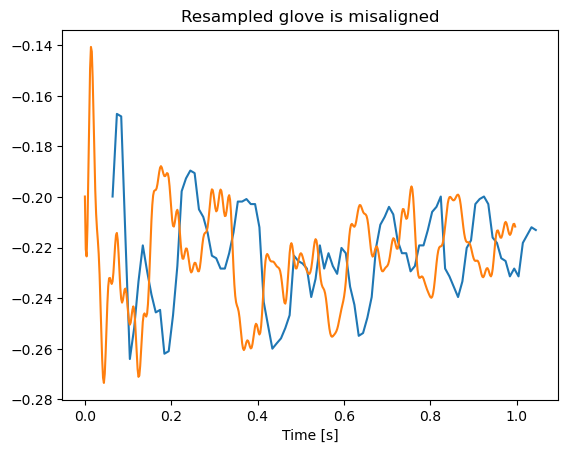

In [172]:
glove_ch = 0
dur_s = 1

n_glove = int(glove_sfreq*dur_s)
n_eeg = int(eeg_sfreq*dur_s)

plt.plot(glove_t[:n_glove], glove_data[:n_glove, glove_ch])
plt.plot(eeg_t[:n_eeg], glove_data_rs[:n_eeg, glove_ch])

plt.title('Resampled glove is misaligned')
plt.xlabel('Time [s]')
plt.show()

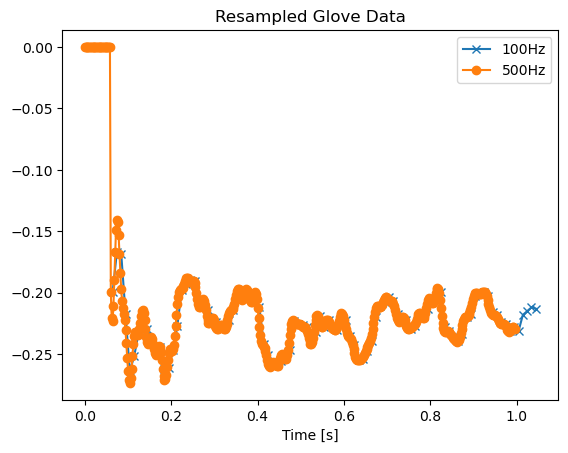

In [173]:
delay = 6*5 # where is this delay coming from?
zero_pad = np.zeros(shape=(delay, 6))

# Zero padded to balance the delay
glove_data_rs_zp = np.vstack((zero_pad, glove_data_rs))

# Plot one glove channel to visualize
glove_ch = 0
dur_s = 1

n_glove = int(glove_sfreq*dur_s)
n_eeg = int(eeg_sfreq*dur_s)

plt.plot(glove_t[:n_glove], glove_data[:n_glove, glove_ch], '-x', label='100Hz')
plt.plot(eeg_t[:n_eeg], glove_data_rs_zp[:n_eeg, glove_ch], '-o', label='500Hz')

plt.title('Resampled Glove Data')
plt.legend()
plt.xlabel('Time [s]')
plt.show()

# Collect channel names and types

In [174]:
ch_names = eeg_ch_names[:32]
ch_names.extend(['glove_acc_x',
                 'glove_acc_y', 
                 'glove_acc_z', 
                 'glove_yaw', 
                 'glove_pitch', 
                 'glove_roll'])
ch_names.extend(['TRIGGER'])
ch_names

['AF7',
 'Fpz',
 'F7',
 'Fz',
 'T7',
 'FC6',
 'Fp1',
 'F4',
 'C4',
 'Oz',
 'CP6',
 'Cz',
 'PO8',
 'CP5',
 'O2',
 'O1',
 'P3',
 'P4',
 'P7',
 'P8',
 'Pz',
 'PO7',
 'T8',
 'C3',
 'Fp2',
 'F3',
 'F8',
 'FC5',
 'AF8',
 'A2',
 'ExG 1',
 'ExG 2',
 'glove_acc_x',
 'glove_acc_y',
 'glove_acc_z',
 'glove_yaw',
 'glove_pitch',
 'glove_roll',
 'TRIGGER']

(Manually) Identify each channel's type for importing data to mne:

In [175]:
ch_types = []
ch_types.extend(['eeg']*30) # first 30 channels are EEG (including A2)
ch_types.extend(['emg']*2) # ExG x2
ch_types.extend(['misc']*6) # glove IMU
ch_types.extend(['stim']) # Trigger channel

Make an info object for importing data to mne:

https://mne.tools/stable/generated/mne.create_info.html

In [176]:
info = mne.create_info(
    ch_names = ch_names,
    sfreq = eeg_sfreq,
    ch_types = ch_types,
)

Import the data as a raw array:

https://mne.tools/stable/generated/mne.io.RawArray.html

In [177]:
glove_data_rs_zp.shape

(339200, 6)

In [178]:
eeg_data.shape

(339269, 37)

In [185]:
stim_data = eeg_data[:, -1]
stim_data.shape

(339269,)

In [186]:
stim_data = stim_data[:, np.newaxis]

In [187]:
data = np.hstack(
    (
        eeg_data[:len(glove_data_rs_zp), :32], # EEG and EMG channels
        glove_data_rs_zp,
        stim_data[:len(glove_data_rs_zp), :], # trigger channel
    )
)
data.shape

(339200, 39)

In [188]:
raw = mne.io.RawArray(
    data = data.T, # mne expects (n_channels, n_times)
    info = info,
)

raw

Creating RawArray with float64 data, n_channels=39, n_times=339200
    Range : 0 ... 339199 =      0.000 ...   678.645 secs
Ready.


<RawArray | 39 x 339200 (678.6 s), ~101.0 MB, data loaded>

## Apply the 10-20 channel montage

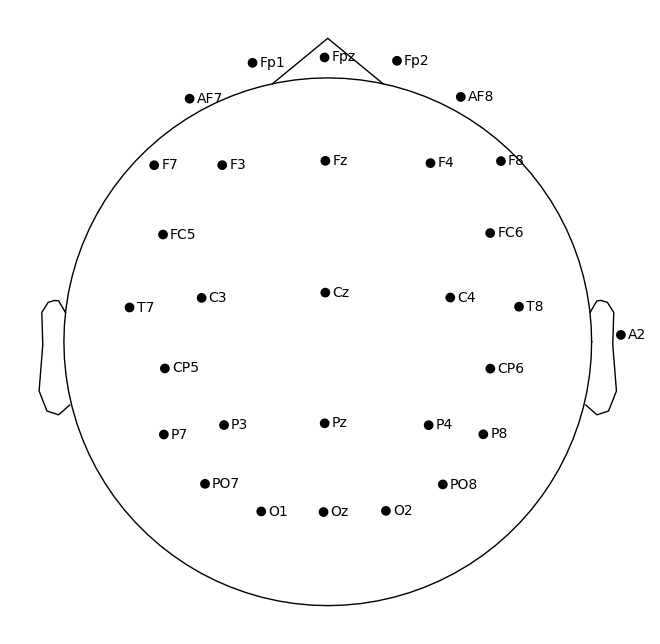

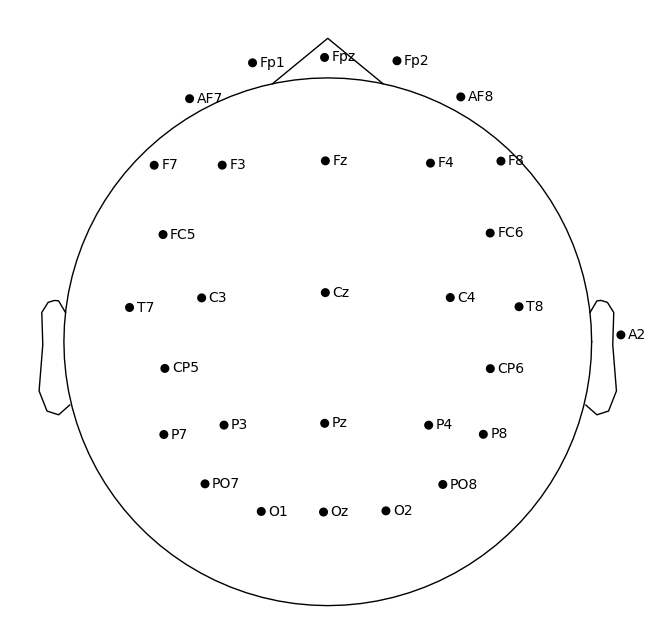

In [189]:
raw.info.set_montage('standard_1020', match_case=False)

# Plot the montage
mne.viz.plot_montage(raw.info.get_montage())

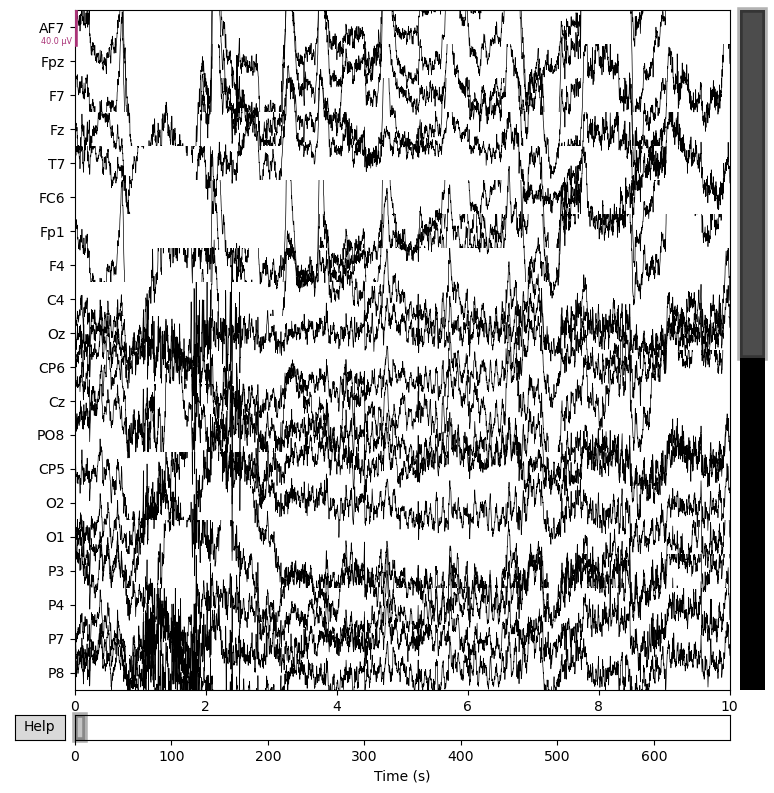

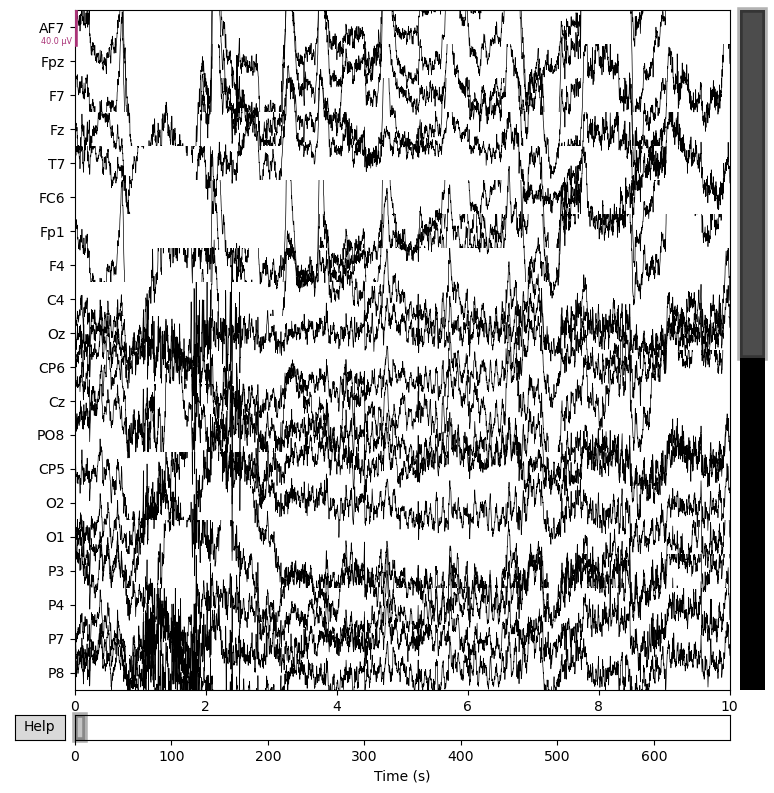

In [190]:
raw.plot()

# Add annotations from MIDI stream

In [191]:
lsl_streams['MIDI']

{'data': array([[  0,  66,   1],
        [  0,  66,  64],
        [  0,  60, 121],
        ...,
        [  0,  55,  64],
        [  0,  75,  95],
        [  0,  75,  64]], dtype=int32),
 'time': array([ 15.37874608,  16.63524483,  26.76071229, ..., 625.60872412,
        625.97964564, 626.51918914])}

In [192]:
midi_q = {}
midi_events = []

for i, msg in enumerate(lsl_streams['MIDI']['data']):
    
    _ = msg[0] # could set this to be note_on or note_off events
    note = msg[1]
    velocity = msg[2]
    
    if not note in midi_q:
        on_t = lsl_streams['MIDI']['time'][i]
        midi_q[note] = {}
        midi_q[note]['onset'] = on_t
        midi_q[note]['velocity'] = velocity
        
    else: # note is already ON
        if velocity == 64: # OFF event
            off_t = lsl_streams['MIDI']['time'][i]
            midi_events.append(
                [
                    midi_q[note]['onset'], # start time
                    off_t - midi_q[note]['onset'], # duration
                    librosa.midi_to_note(note)
                ]
            )
            midi_q.pop(note, None) # remove note from the queue
            
midi_events = np.array(midi_events) # for easier indexing
midi_events

array([['15.378746078000404', '1.2564987561199814', 'F♯4'],
       ['26.76071229064837', '0.7380193946883082', 'C4'],
       ['28.07648038410116', '0.5056933019077405', 'G4'],
       ...,
       ['624.4921949084383', '0.5522632503416389', 'G♯3'],
       ['625.2456768850097', '0.363047237158753', 'G3'],
       ['625.979645641055', '0.5395434950478375', 'D♯5']], dtype='<U32')

In [193]:
lsl_annot = mne.Annotations(
    onset = midi_events[:, 0],
    duration = midi_events[:, 1], # setting durations to 0 to just label event onsets
    description = midi_events[:, 2]
)

raw.set_annotations(lsl_annot)

<RawArray | 39 x 339200 (678.6 s), ~101.0 MB, data loaded>

# Lets find events from annotations

In [194]:
events, event_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['A3', 'A4', 'A♯3', 'A♯4', 'B3', 'B4', 'C3', 'C4', 'C5', 'C♯3', 'C♯4', 'D3', 'D4', 'D5', 'D♯3', 'D♯4', 'D♯5', 'E3', 'E4', 'E5', 'F3', 'F4', 'F5', 'F♯3', 'F♯4', 'G2', 'G3', 'G4', 'G5', 'G♯2', 'G♯3', 'G♯4']


# Bandpass Filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


Effective window size : 2.049 (s)


/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


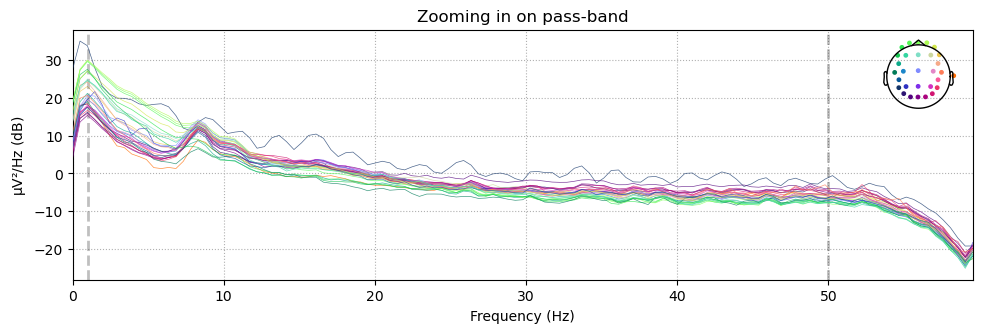

In [195]:
l_freq = 1
h_freq = 50

raw_filt = raw.copy().filter( # make a copy of the array to avoid modifying in place
    l_freq = l_freq, # lower cut-off, in Hz
    h_freq = h_freq, # upper cut-off, in Hz
)


n_fft = 1024

# picks = [''] # a list of channels that you want to focus on, if any
fig = raw_filt.compute_psd(
    # picks= picks,
    fmin = 0, # lower limit to plot
    fmax = 60, # upper limit to plot
    # tmin = 0, # if only using a subset of the data for PSD computation
    # tmax = 10,
    n_fft = n_fft,
).plot()

# Some reformatting if needed
# fig.get_axes()[0].set_ylim(YLIM_MIN, YLIM_MAX)
fig.get_axes()[0].set_title('Zooming in on pass-band')
plt.show()

# Drop bad channels
(since ERPs showed these channels as suspect)

In [216]:
raw_filt.info.bads = ['P7'] #'Oz', 'O1', , 'Fp2', 'F7', 'P3'] # ideally could label bad segments instead of dropping channels

# Drop bad channels from visual examination before running ICA
raw_filt_drop_bad = raw_filt.copy().drop_channels(raw_filt.info.bads)

# Make Epochs

In [246]:
eps = mne.Epochs(
    raw_filt_drop_bad,
    # raw_filt_drop_bad, 
    # raw,
    # picks = ['eeg'],
    events = events, 
    event_id = event_id, 
    tmin=-1,
    tmax= 1,
    baseline=None,
    event_repeated = 'drop',
)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
571 matching events found
No baseline correction applied
0 projection items activated


# Get Data for Baseline DSS
(without using glove data, just uses average of all epochs as bias)

In [219]:
n_eeg_ch = 30-1 # one removed above
DSS_data = eps.get_data().T[:, :n_eeg_ch, :] # time x channels x epochs
DSS_data.shape

Using data from preloaded Raw for 571 events and 1001 original time points ...


(1001, 29, 571)

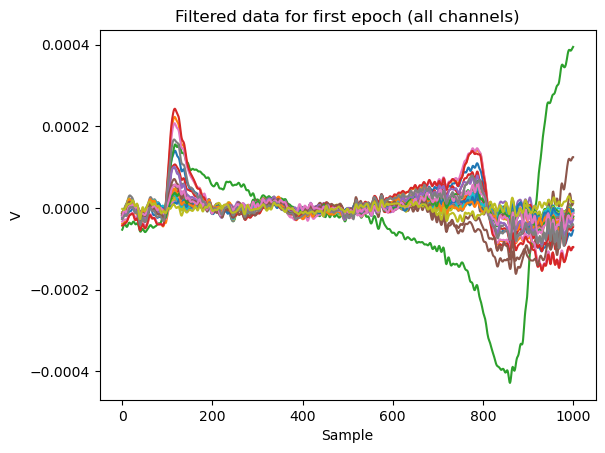

In [220]:
plt.plot(DSS_data[:,:,0]) # plot first epoch
plt.title('Filtered data for first epoch (all channels)')
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()

## Get bias for DSS

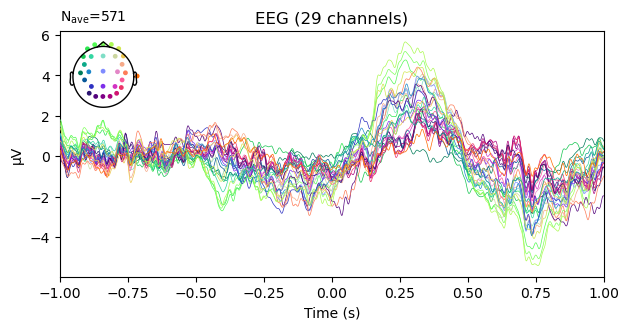

In [221]:
# %matplotlib widget 
eps.average(
    picks = ['eeg'],
    # picks=['Fz', 'Cz', 'Pz', 'Oz', 'C3', 'C4']
).plot()
plt.show()

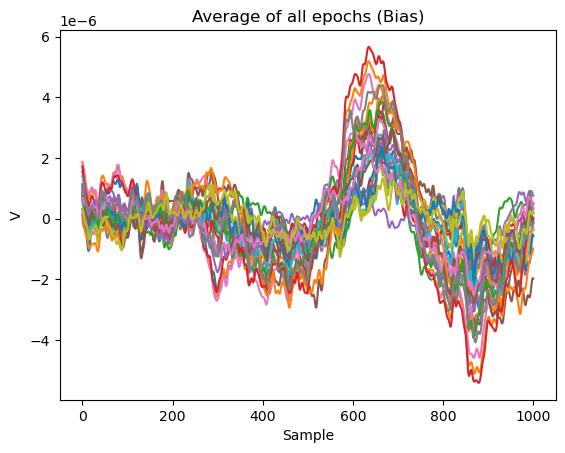

In [222]:
bias_data = eps.average(
    picks = ['eeg'],
    # picks=['Fz', 'Cz', 'Pz', 'Oz', 'C3', 'C4']
)._data.T

# This should be the same as the mne plot abive
plt.figure()
plt.plot(bias_data)
plt.title('Average of all epochs (Bias)')
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()

In [223]:
bias_data.shape # time x channels

(1001, 29)

# Run DSS

In [261]:
def run_dss(
    DSS_data, # time x channels x epochs
    bias_data, # time x channels
    TOKEEP = [0, 1], # DSS components to keep for calculating xx
    keep2 = 10e-100000,
):
    # DSS code from Claire
    c0, _ = tscov(DSS_data) #[:,0:nchans,:])
    fig = plt.imshow(c0, cmap=None, interpolation=None)
    plt.colorbar()
    plt.title("Covariance Matrix - EEG data")
    plt.show()

    # In this case the biased covariance is simply the covariance of the mean over
    # trials
    c1, _ = tscov(bias_data)
    fig = plt.imshow(c1, cmap=None, interpolation=None)
    plt.colorbar()
    plt.title("Covariance Matrix - Noise channel")
    plt.show()

    # Apply DSS
    [todss, fromdss, pwr0, pwr1] = dss.dss0(c0, c1, keep1=DSS_data.shape[0], keep2=keep2)
    print(todss.shape)

    # plot components explaining variance
    plt.figure()
    plt.clf()
    plt.plot(pwr1 / pwr0, '.-')
    plt.title('repeatability')
    plt.xlabel('component')
    plt.ylabel('score')
    plt.show()

    # which composants to keep?
    # TOKEEP = [0, 1] #range(2, nchans) #[0] #range(2) #range(nchans-2)

    z = fold(np.dot(unfold(DSS_data), todss), epoch_size=DSS_data.shape[0])

    best_comp = np.mean(z[:, 0, :], -1)

    xx = fold(np.dot(unfold(DSS_data), todss[:, TOKEEP] @ fromdss[TOKEEP, :]), epoch_size=DSS_data.shape[0])
    
    return best_comp, xx, z

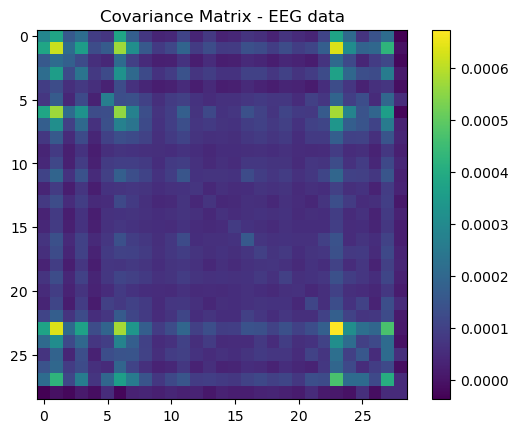

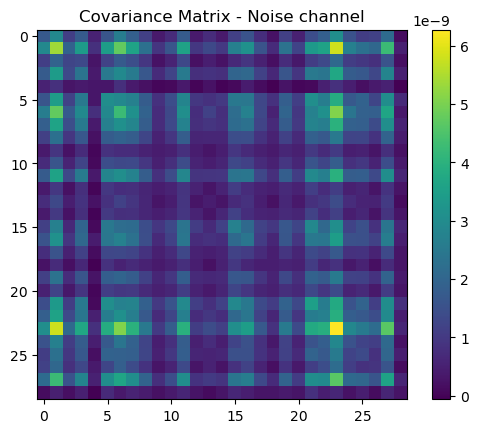

(29, 29)


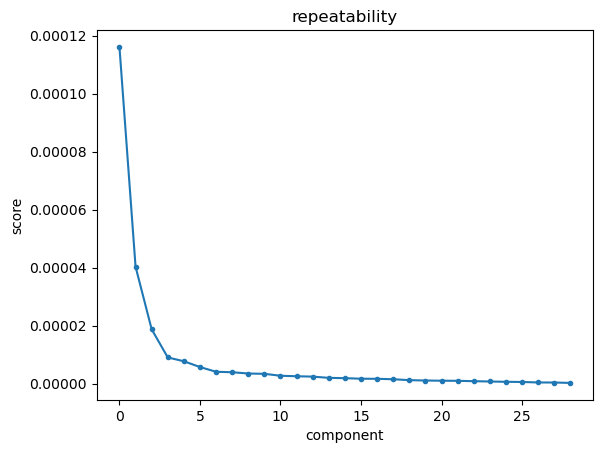

In [423]:
TOKEEP_BASELINE = [0, 1]
best_comp, xx, z = run_dss(
    DSS_data, 
    bias_data, 
    TOKEEP = TOKEEP_BASELINE,
)

In [328]:
xx.shape

(1001, 29, 571)

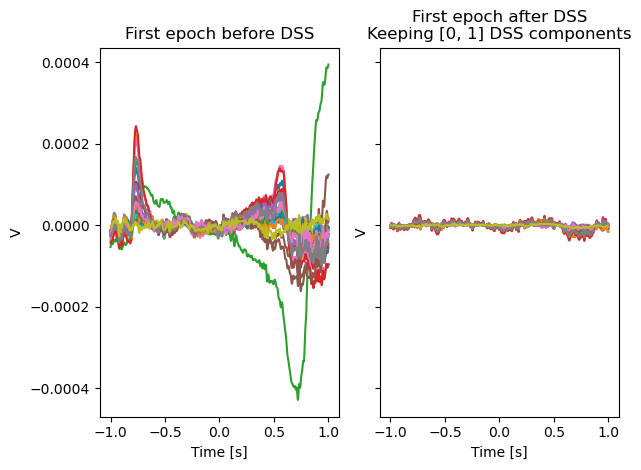

In [331]:
fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].plot(eps.times, DSS_data[:, :, 0])

ax[0].set_title('First epoch before DSS')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('V')

ax[1].plot(eps.times, xx[:, :, 0])

ax[1].set_title(f'First epoch after DSS\nKeeping {TOKEEP} DSS components')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('V')

plt.tight_layout()
plt.show()

# Normalize the components to compare

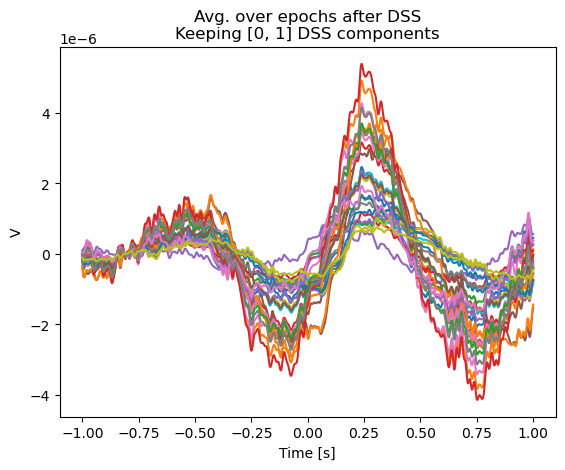

In [335]:
# Not sure why this is not going from -1 to 1?
xx_avg = np.mean(xx, -1) #/np.max(np.abs(xx))

plt.plot(eps.times, xx_avg)
plt.xlabel('Time [s]')
plt.ylabel('V')
plt.title(f'Avg. over epochs after DSS\nKeeping {TOKEEP} DSS components')
# plt.plot(best_comp_norm, '--', lw=2)
plt.show()

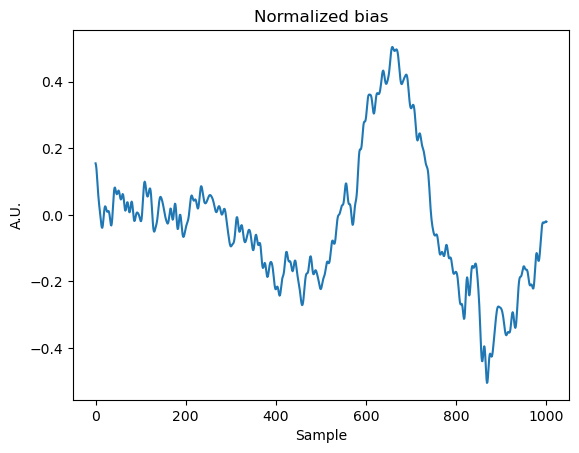

In [337]:
bias_data_norm = np.mean(bias_data, -1)/np.max(np.abs(bias_data))
plt.plot(bias_data_norm)
plt.title('Normalized bias')
plt.xlabel('Sample')
plt.ylabel('A.U.')
plt.show()

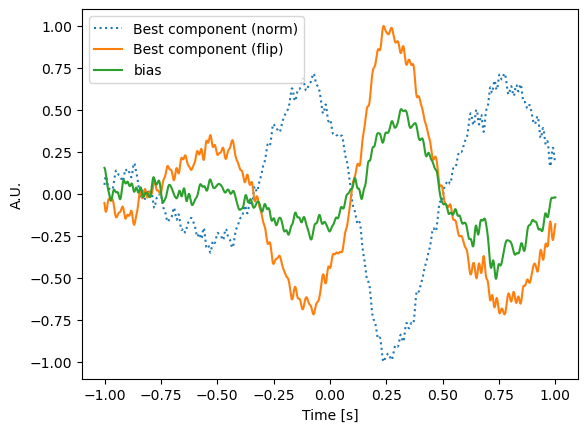

In [341]:
best_comp_norm = best_comp/np.max(np.abs(best_comp))
                                  
plt.plot(eps.times, best_comp_norm, ':', label = 'Best component (norm)')
plt.plot(eps.times, -best_comp_norm, label = 'Best component (flip)')
plt.plot(eps.times, bias_data_norm, label = 'bias')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('A.U.')
plt.show()

# Rerun DSS with glove as bias

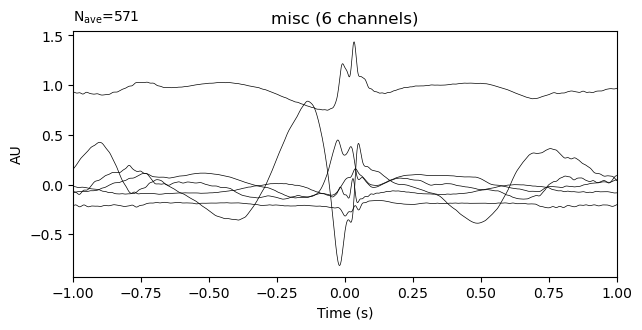

In [342]:
eps.average(
    picks=['misc'], # misc. channels are glove IMU
).plot()
plt.show()

In [343]:
bias_data_glove = eps.average(
    picks = ['misc'],
    # picks=['Fz', 'Cz', 'Pz', 'Oz', 'C3', 'C4']
)._data.T
bias_data_glove.shape

(1001, 6)

## Pick 6 EEG channels 
to match glove channel count

In [346]:
eps.load_data() # need to preload data to be able to pick channels
eps_6ch = eps.copy().pick_channels(['Fz', 'Cz', 'Pz', 'Oz', 'C3', 'C4'])

In [347]:
DSS_data_6ch = eps_6ch.get_data().T # time x channels x epochs
DSS_data_6ch.shape

(1001, 6, 571)

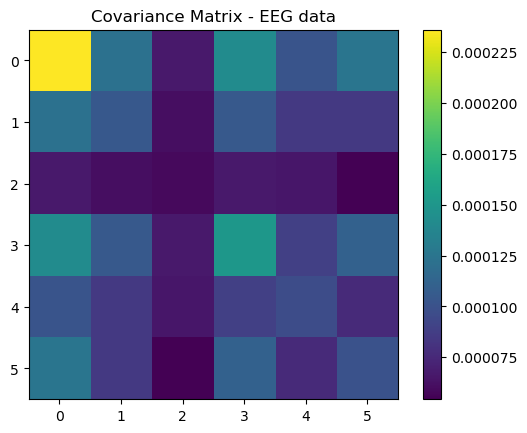

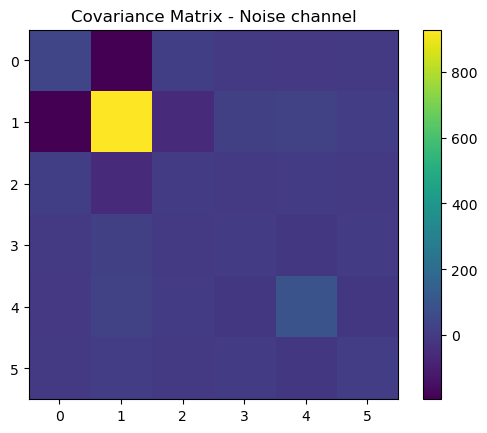

(6, 6)


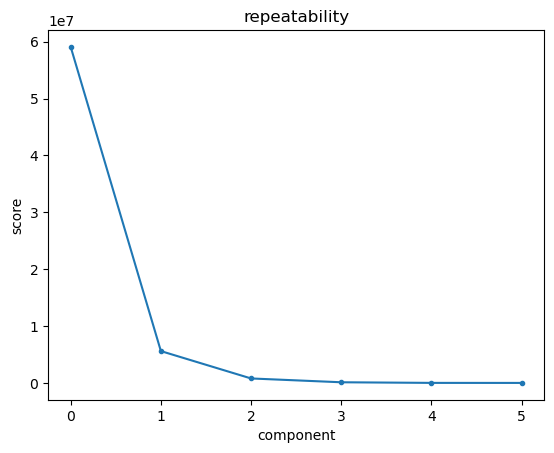

In [414]:
TOKEEP_6CH = [2, 3, 4, 5] # [0, 1],
best_comp_glove, xx_glove, z_glove = run_dss(
    DSS_data_6ch,
    bias_data_glove,
    TOKEEP = TOKEEP_6CH,
)

In [415]:
xx_glove.shape

(1001, 6, 571)

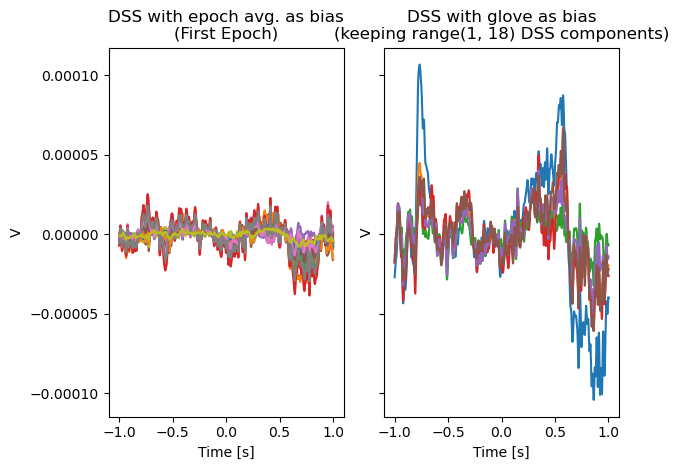

In [416]:
fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].plot(eps.times, xx[:, :, 0])

ax[0].set_title('DSS with epoch avg. as bias\n(First Epoch)')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('V')

ax[1].plot(eps.times, xx_glove[:, :, 0])

ax[1].set_title(f'DSS with glove as bias\n(keeping {TOKEEP} DSS components)')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('V')

plt.tight_layout()
plt.show()

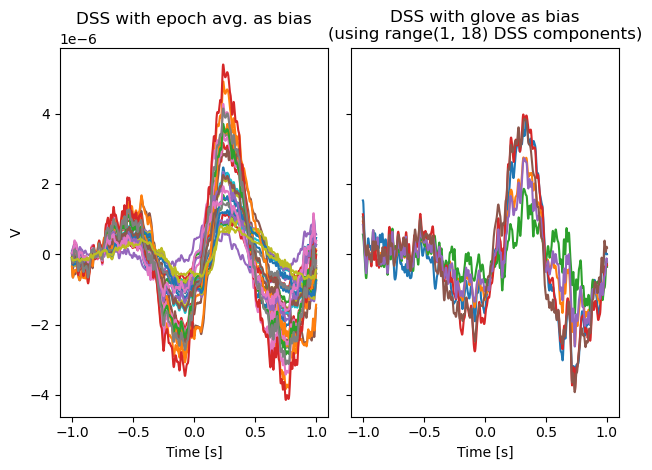

In [417]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

# Not sure why this is not going from -1 to 1?
xx_avg = np.mean(xx, -1) #/np.max(np.abs(xx))

ax[0].plot(eps.times, xx_avg)
ax[0].set_title(f'DSS with epoch avg. as bias')
# plt.plot(best_comp_norm, '--', lw=2)

# Not sure why this is not going from -1 to 1?
xx_glove_avg = np.mean(xx_glove, -1) #/np.max(np.abs(xx_glove))

ax[1].plot(eps.times, xx_glove_avg)
# plt.plot(best_comp_norm, '--', lw=2)
ax[1].set_title(f'DSS with glove as bias\n(using {TOKEEP} DSS components)')
ax[1].set_xlabel('Time [s]')

ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('V')

plt.tight_layout()
plt.show()

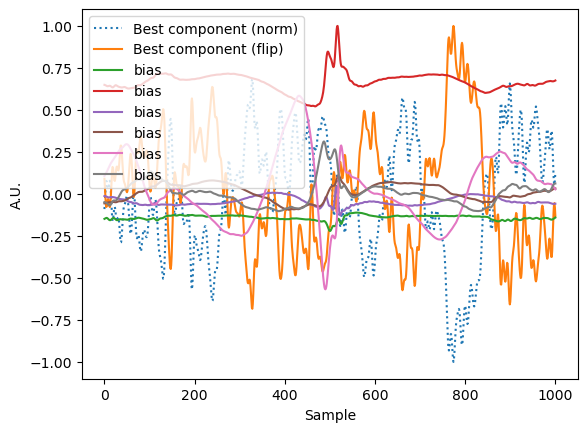

In [418]:
best_comp_glove_norm = best_comp_glove/np.max(np.abs(best_comp_glove))
bias_data_glove_norm = bias_data_glove/np.max(np.abs(bias_data_glove))
                        
plt.plot(best_comp_glove_norm, ':', label = 'Best component (norm)')
plt.plot(-best_comp_glove_norm, label = 'Best component (flip)')
plt.plot(bias_data_glove_norm, label = 'bias')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('A.U.')
plt.show()

# Add zero'd glove channels
to match EEG channel count

In [344]:
bias_data_glove_zp = np.hstack(
    (
        bias_data_glove, # EEG and EMG channels
        np.zeros(shape=(
            bias_data_glove.shape[0],
            DSS_data.shape[1] - bias_data_glove.shape[1],
        )),
    )
)
bias_data_glove_zp.shape

(1001, 29)

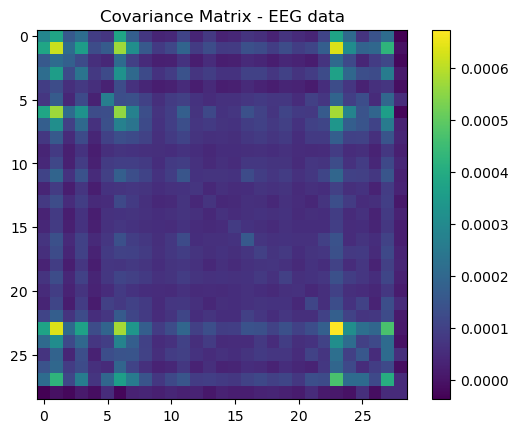

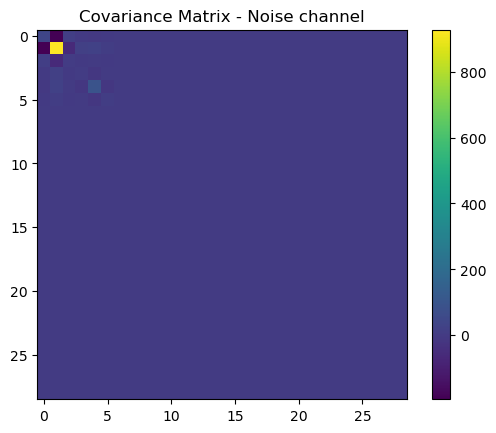

(29, 18)


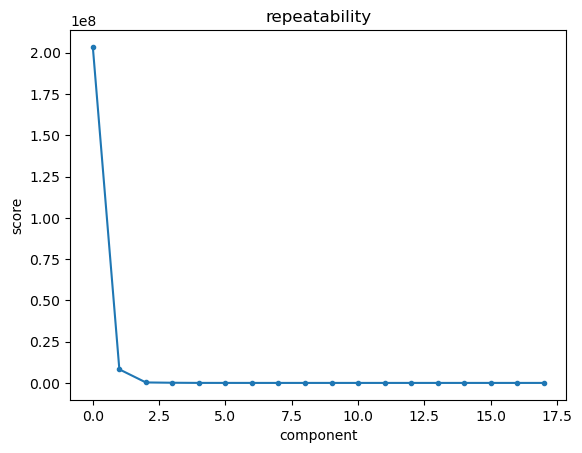

In [419]:
TOKEEP_GLOVE = range(1, 18) # [0, 1],
best_comp_glove_zp, xx_glove_zp, z_glove_zp = run_dss(
    DSS_data,
    bias_data_glove_zp,
    TOKEEP = TOKEEP_GLOVE,
)

### Can't normalize and compare xx!

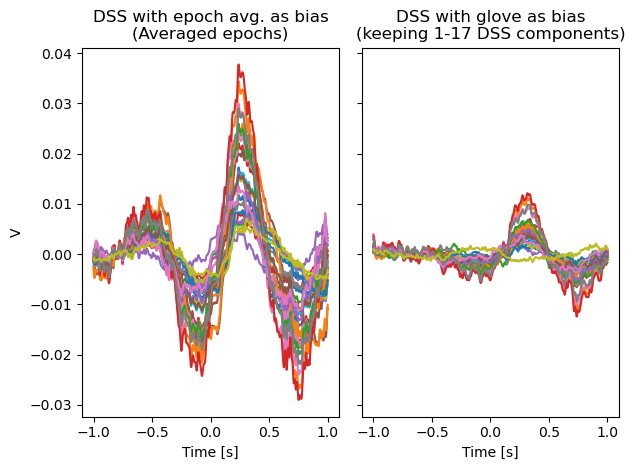

In [420]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

# Not sure why this is not going from -1 to 1?
xx_avg = np.mean(xx, -1) /np.max(np.abs(xx))

ax[0].plot(eps.times, xx_avg)
ax[0].set_title(f'DSS with epoch avg. as bias\n(Averaged epochs)')
# plt.plot(best_comp_norm, '--', lw=2)

# Not sure why this is not going from -1 to 1?
xx_glove_zp_avg = np.mean(xx_glove_zp, -1) /np.max(np.abs(xx_glove_zp))

ax[1].plot(eps.times, xx_glove_zp_avg)
# plt.plot(best_comp_norm, '--', lw=2)
ax[1].set_title(f'DSS with glove as bias\n(keeping {TOKEEP_GLOVE[0]}-{TOKEEP_GLOVE[-1]} DSS components)')
ax[1].set_xlabel('Time [s]')

ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('V')

plt.tight_layout()
plt.show()

# Comparing epoch avg. vs. glove bias

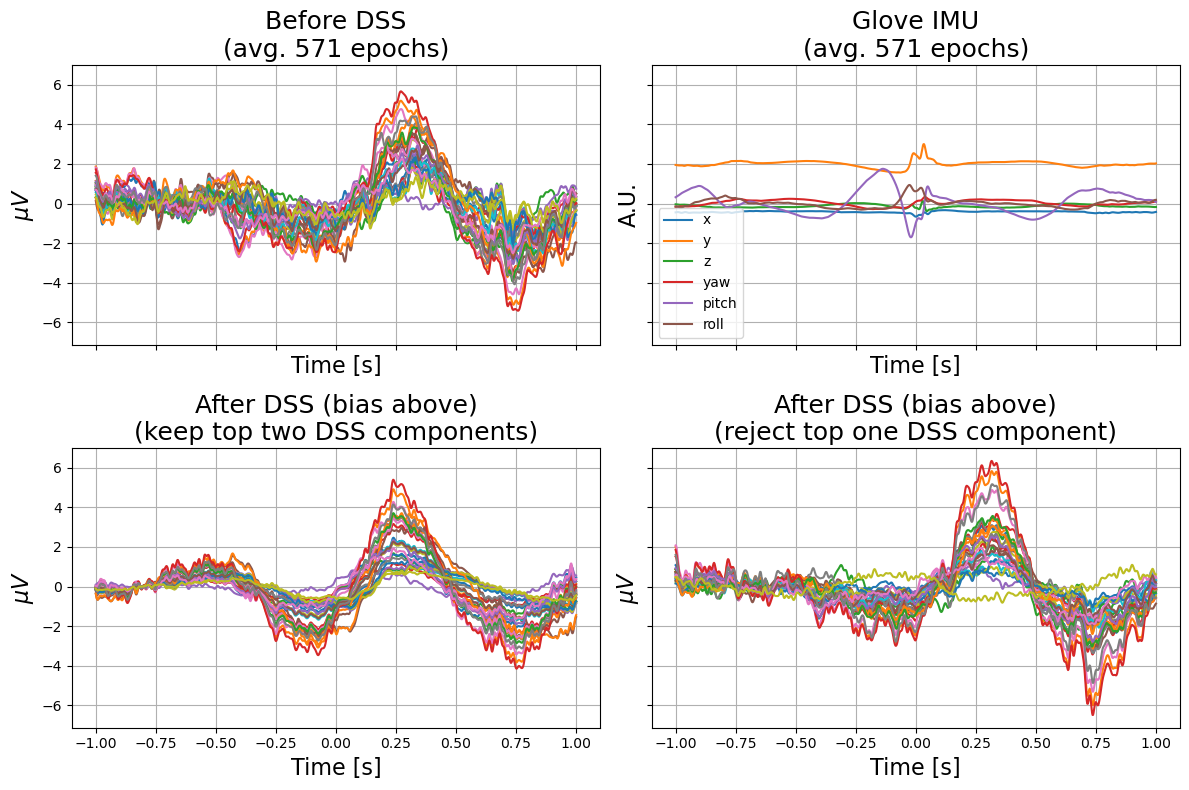

In [443]:
fig, ax = plt.subplots(2, 2, 
                       figsize=(12, 8),
                       sharex=True, 
                       sharey=True)

# Averaged epochs (before DSS)
ax[0][0].plot(eps.times, np.mean(DSS_data, -1)*1e6)
ax[0][0].set_xlabel('Time [s]', fontsize=16)
ax[0][0].set_ylabel('$\mu V$', fontsize=16)
ax[0][0].set_title(f'Before DSS\n(avg. {DSS_data.shape[-1]} epochs)', fontsize=18)

# Averaged epochs after DSS (epoch avg. as bias)
# Not sure why this is not going from -1 to 1?
xx_avg = np.mean(xx, -1) #/np.max(np.abs(xx))

ax[1][0].plot(eps.times, xx_avg*1e6)
ax[1][0].set_title(f'After DSS (bias above)\n(keep top two DSS components)', fontsize=18)
# plt.plot(best_comp_norm, '--', lw=2)
ax[1][0].set_xlabel('Time [s]', fontsize=16)
ax[1][0].set_ylabel('$\mu V$', fontsize=16)

# Bias used
ax[0][1].plot(eps.times, 3*bias_data_glove/np.max(np.abs(bias_data_glove)))
ax[0][1].set_xlabel('Time [s]', fontsize=16)
ax[0][1].set_ylabel('A.U.', fontsize=16)
ax[0][1].set_title(f'Glove IMU\n(avg. {DSS_data.shape[-1]} epochs)', fontsize=18)
ax[0][1].legend(['x', 'y', 'z', 'yaw', 'pitch', 'roll'])

# Not sure why this is not going from -1 to 1?
xx_glove_zp_avg = np.mean(xx_glove_zp, -1) #/np.max(np.abs(xx_glove_zp))

ax[1][1].plot(eps.times, xx_glove_zp_avg * 1e6)
# plt.plot(best_comp_norm, '--', lw=2)
ax[1][1].set_title(f'After DSS (bias above)\n(reject top one DSS component)', fontsize=18)
ax[1][1].set_xlabel('Time [s]', fontsize=16)
ax[1][1].set_ylabel('$\mu V$', fontsize=16)

#plt.axis('square')
plt.tight_layout()
ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()

plt.show()

# Rerun DSS on avg. epoch bias DSS

In [444]:
xx.shape

(1001, 29, 571)

In [445]:
bias_data_glove_zp.shape

(1001, 29)

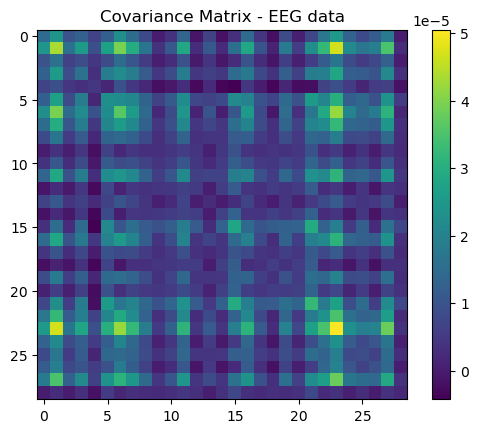

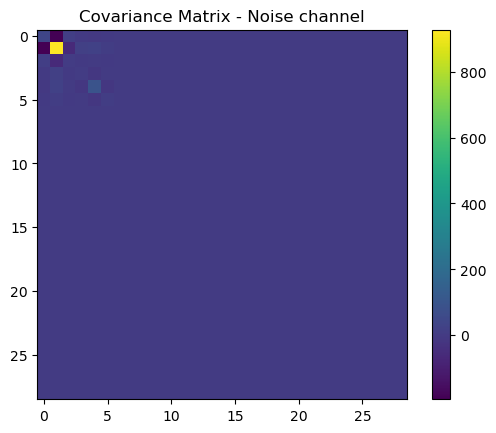

(29, 9)


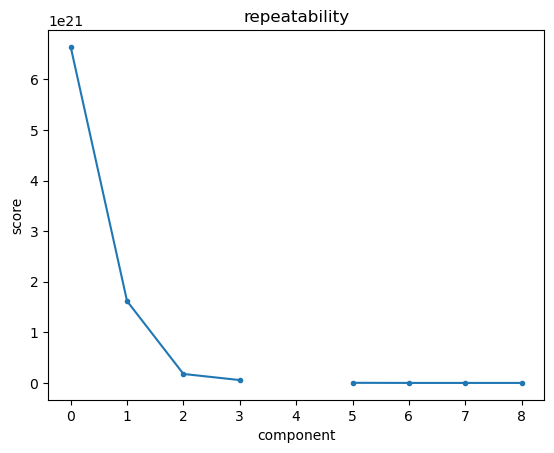

In [473]:
TOKEEP_DSS2 = [1, 2, 3, 5, 6, 7, 8] # [0, 1],
best_comp_dss2, xx_dss2, z_dss2 = run_dss(
    xx,
    bias_data_glove_zp,
    TOKEEP = TOKEEP_DSS2,
)

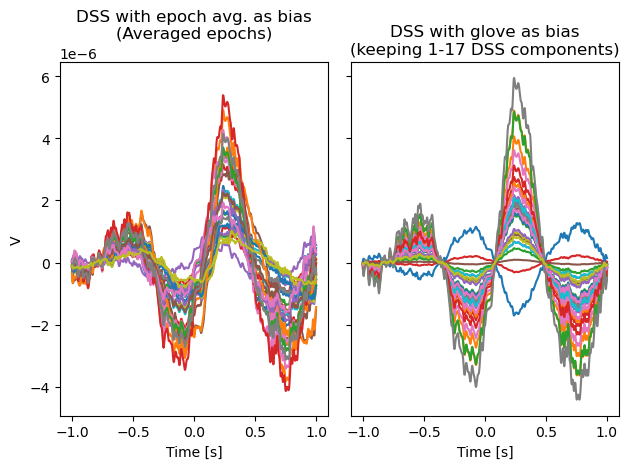

In [474]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

# Not sure why this is not going from -1 to 1?
xx_avg = np.mean(xx, -1) #/np.max(np.abs(xx))

ax[0].plot(eps.times, xx_avg)
ax[0].set_title(f'DSS with epoch avg. as bias\n(Averaged epochs)')
# plt.plot(best_comp_norm, '--', lw=2)

# Not sure why this is not going from -1 to 1?
xx_dss2_avg = np.mean(xx_dss2, -1) #/np.max(np.abs(xx_glove_zp))

ax[1].plot(eps.times, xx_dss2_avg)
# plt.plot(best_comp_norm, '--', lw=2)
ax[1].set_title(f'DSS with glove as bias\n(keeping {TOKEEP_GLOVE[0]}-{TOKEEP_GLOVE[-1]} DSS components)')
ax[1].set_xlabel('Time [s]')

ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('V')

plt.tight_layout()
plt.show()

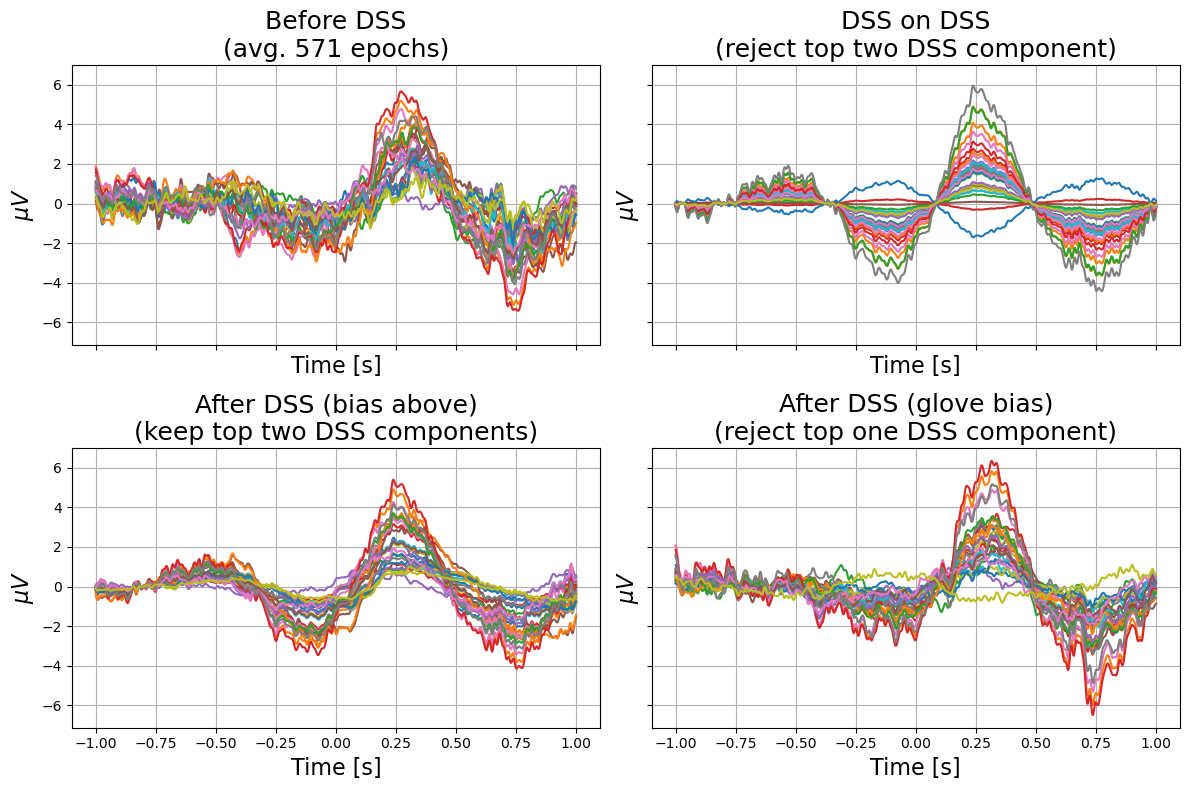

In [475]:
fig, ax = plt.subplots(2, 2, 
                       figsize=(12, 8),
                       sharex=True, 
                       sharey=True)

# Averaged epochs (before DSS)
ax[0][0].plot(eps.times, np.mean(DSS_data, -1)*1e6)
ax[0][0].set_xlabel('Time [s]', fontsize=16)
ax[0][0].set_ylabel('$\mu V$', fontsize=16)
ax[0][0].set_title(f'Before DSS\n(avg. {DSS_data.shape[-1]} epochs)', fontsize=18)

# Averaged epochs after DSS (epoch avg. as bias)
# Not sure why this is not going from -1 to 1?
xx_avg = np.mean(xx, -1) #/np.max(np.abs(xx))

ax[1][0].plot(eps.times, xx_avg*1e6)
ax[1][0].set_title(f'After DSS (bias above)\n(keep top two DSS components)', fontsize=18)
# plt.plot(best_comp_norm, '--', lw=2)
ax[1][0].set_xlabel('Time [s]', fontsize=16)
ax[1][0].set_ylabel('$\mu V$', fontsize=16)

xx_dss2_avg = np.mean(xx_dss2, -1)

ax[0][1].plot(eps.times, xx_dss2_avg*1e6)
ax[0][1].set_xlabel('Time [s]', fontsize=16)
ax[0][1].set_ylabel('$\mu V$', fontsize=16)
ax[0][1].set_title(f'DSS on DSS\n(reject top two DSS component)', fontsize=18)

# Not sure why this is not going from -1 to 1?
xx_glove_zp_avg = np.mean(xx_glove_zp, -1) #/np.max(np.abs(xx_glove_zp))

ax[1][1].plot(eps.times, xx_glove_zp_avg * 1e6)
# plt.plot(best_comp_norm, '--', lw=2)
ax[1][1].set_title(f'After DSS (glove bias)\n(reject top one DSS component)', fontsize=18)
ax[1][1].set_xlabel('Time [s]', fontsize=16)
ax[1][1].set_ylabel('$\mu V$', fontsize=16)

#plt.axis('square')
plt.tight_layout()
ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()

plt.show()

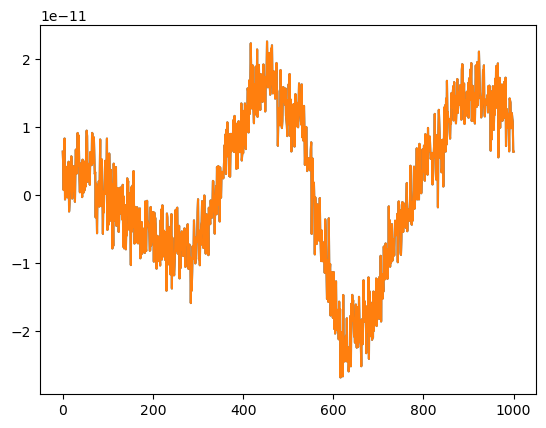

In [477]:
plt.plot(best_comp_dss2)
plt.show()

In [478]:
z_dss2.shape

(1001, 9, 571)

In [480]:
z_dss2_avg = np.mean(z_dss2, -1)
z_dss2_avg.shape

(1001, 9)

In [483]:
z_dss2_avg[:, 4] = 0 # bad component

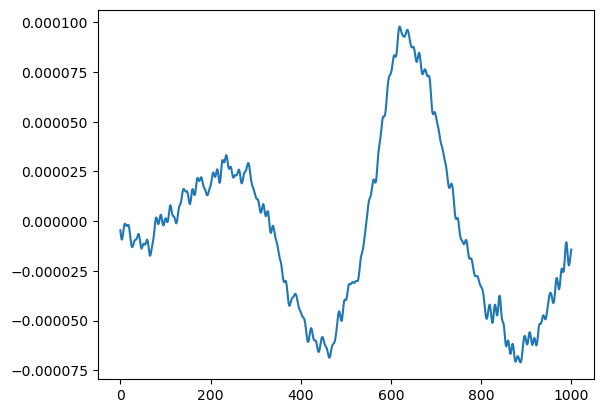

In [486]:
z_dss2_avg_rej0 = np.mean(z_dss2_avg[:, 1:], axis=1)
plt.plot(z_dss2_avg_rej0)
plt.show()